In [1]:
import torch
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colormaps 
from matplotlib.cm import ScalarMappable
from matplotlib.colors import PowerNorm
import pandas as pd 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.double)
pyplot_style ={"text.usetex": True,
               "text.latex.preamble": r"\usepackage{amsfonts}\usepackage[version=4]{mhchem}",
               "axes.spines.right" : False,
               "axes.spines.top" : False,
               "font.size": 22,
               "savefig.dpi": 600,
               "savefig.bbox": 'tight',
              } 

design_space_bounds = [(0.0, 35.0), (0.0, 35.0)]

def prettify_axis(ax):
    # ax.set_xlabel(r"Silver Nitrate ($10^{-4}$ M)")
    # ax.set_ylabel(r"Ascorbic Acid ($10^{-3}$ M)")
    ax.set_xlim(*design_space_bounds[0])
    ax.set_ylim(*design_space_bounds[1])
    ax.xaxis.set_major_locator(ticker.LinearLocator(3))
    ax.yaxis.set_major_locator(ticker.LinearLocator(5))
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))

    SN_labels = [item.get_text() for item in ax.get_xticklabels()]
    SN_vol_to_conc = lambda v : (6.4*v)/(300)
    SN_conc_labels = []
    for l in SN_labels:
        SN_conc_labels.append("%.2f"%SN_vol_to_conc(float(l)))
    ax.set_xticklabels(SN_conc_labels)

    AA_labels = [item.get_text() for item in ax.get_yticklabels()]
    AA_vol_to_conc = lambda v : (6.3*v)/(300)
    AA_conc_labels = []
    for l in AA_labels:
        AA_conc_labels.append("%.2f"%AA_vol_to_conc(float(l)))
    ax.set_yticklabels(AA_conc_labels)

    return ax

In [2]:
tem_select_ind = [41, 49, 101, 69, 109, 124, 145, 166, 141, 323, 325, 327, 
                  124, 145, 166,
                  124, 145, 166
                  ]
expected_labels = ["sphere", "rod", 
                   "seed", "seed", "mix-seed-sphere", 
                   "mix-seed-rod", "rods", "pd-rods", "pd-rods", "md-rods", 
                   "sphere", "sphere", "mix-sphere-rod", "pd-rod", 
                   "pd-rods", "pd-rods", "md-rods",
                   "pd-rods", "pd-rods", "md-rods",
                   ]

/var/folders/84/z8kd1tl11hl96fsszww81rx40000gp/T/ipykernel_2266/4279106281.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(SN_conc_labels)
/var/folders/84/z8kd1tl11hl96fsszww81rx40000gp/T/ipykernel_2266/4279106281.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(AA_conc_labels)


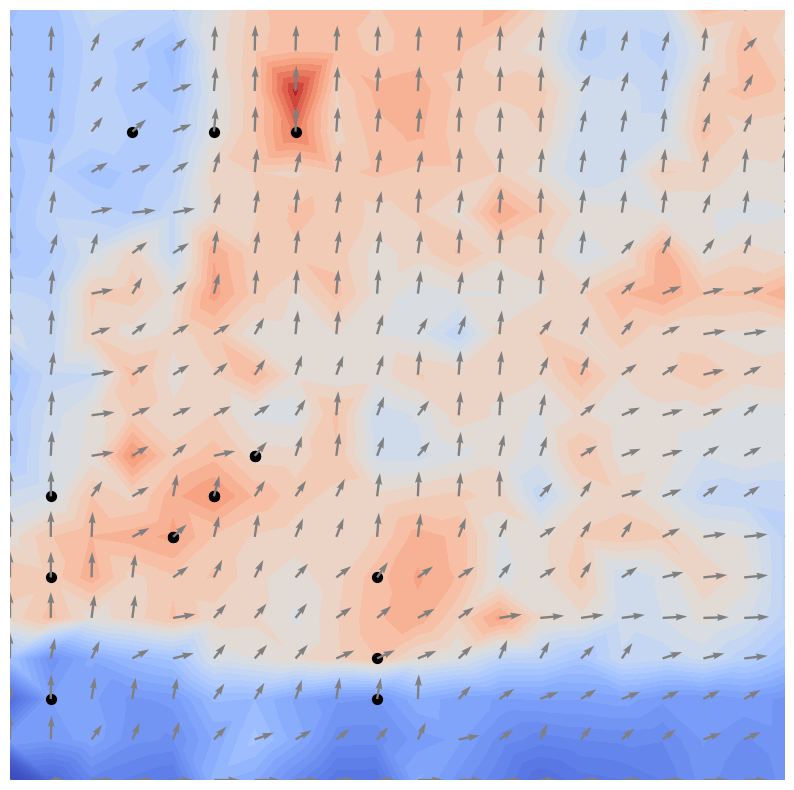

In [15]:
gradient_data = np.load("../paper/data/gradient_data.npz")
grid_data = np.load("../paper/data/grid_data_20.npz")

grid_grad = gradient_data["grid_grad"]
grid_norm = gradient_data["grid_norm"]
grid_comps = grid_data["comps"]
with plt.style.context(pyplot_style):
    fig, ax = plt.subplots(figsize=(10,10))
    flags = grid_norm<100.0
    z = grid_norm[flags] # /max(grid_norm)
    z = np.log(z+1e-5)
    norm = Normalize(vmin=min(z), vmax=max(z))
    norm=PowerNorm(gamma=2.2)
    cmap = "coolwarm"
    contour =  ax.tricontourf(grid_comps[flags,0],
                            grid_comps[flags,1], 
                            z,
                            levels=50,
                            cmap = cmap,
                            norm = norm,
                            )
    # mappable = ScalarMappable(norm=norm, cmap=cmap)
    # divider = make_axes_locatable(ax)
    # cax = divider.append_axes('right', size='3%', pad=0.2)
    # cbar = fig.colorbar(mappable,shrink=0.5, aspect=5,cax=cax)
    # cbar.ax.set_ylabel('gradient norm (log)', rotation=90)
    # ax.scatter(grid_comps[:,0], grid_comps[:,1], s = grid_norm*5,color="k")

    ax.scatter(grid_comps[tem_select_ind,0], grid_comps[tem_select_ind,1], s = 50, color="k")

    # for i in range(grid_comps.shape[0]):
    #     ax.annotate("%d"%i, (grid_comps[i,0], grid_comps[i, 1]))

    U = grid_grad[:,0]
    V = grid_grad[:,1]
    # Normalize the arrows:
    U = U / (grid_norm+1e-3) 
    V = V / (grid_norm+1e-3)
    ax.quiver(grid_comps[:,0], grid_comps[:,1], U, 
            V, 
            color="grey",
            lw=2.0,
            units='width'
            )
    prettify_axis(ax)
    ax.axis("off")
    plt.savefig("./tem_phasemap_selection.png")
    plt.show()

### Read Sphere retrosynthesis

In [4]:
traj = torch.load("../paper/retrosynthesis/sphere/optim_traj.pkl", map_location=torch.device('cpu'))
trajectory = traj["X_traj"][1,...]
sphere_optim = trajectory[-1,:]
print("Sphere retrosynthesis composition : ", sphere_optim)

Sphere retrosynthesis composition :  tensor([ 0.3572, 34.5002])


### Read nanorod retrosynthesis

In [5]:
traj = torch.load("../paper/retrosynthesis/nanorod/optim_traj.pkl", map_location=torch.device('cpu'))
trajectory = traj["X_traj"][2,...]
nanorod_optim = trajectory[-1,:]
print("Nanorod retrosynthesis composition : ", nanorod_optim)

Nanorod retrosynthesis composition :  tensor([19.5415, 22.9251])


### Create opentrons volumes file

In [6]:
comps = np.vstack((sphere_optim, nanorod_optim, grid_comps[tem_select_ind,:]))
comps.shape

(20, 2)

In [7]:
CTAB = 96
GCH = 59
GS = 24 
n_samples = len(comps)
SN = np.round(comps[:,0].reshape(-1,1)).astype(int)
AA = np.round(comps[:,1].reshape(-1,1)).astype(int)
CTAB_ = np.array([CTAB]*n_samples).reshape(-1,1)
GCH_ = np.array([GCH]*n_samples).reshape(-1,1)
GS = np.array([GS]*n_samples).reshape(-1,1)

volumes = np.hstack((CTAB_, GCH_, AA, SN, GS))
WATER = 300 - np.sum(volumes, axis=1).reshape(-1,1)
volumes_ = np.hstack((CTAB_, WATER, GCH_, AA, SN, GS))
volume_df = pd.DataFrame(volumes_, columns=['CTAB', 'Water', 'GCH', 'AA', 'SN', 'GS'])
volume_df

,CTAB,Water,GCH,AA,SN,GS
0,96,86,59,35,0,24
1,96,78,59,23,20,24
2,96,115,59,4,2,24
3,96,100,59,4,17,24
4,96,110,59,9,2,24
5,96,98,59,6,17,24
6,96,95,59,9,17,24
7,96,103,59,11,7,24
8,96,99,59,13,9,24
9,96,95,59,15,11,24


In [8]:
print("Total volumes needed : \n", volume_df.sum())

Total volumes needed : 
 CTAB     1920
Water    1927
GCH      1180
AA        307
SN        186
GS        480
dtype: int64


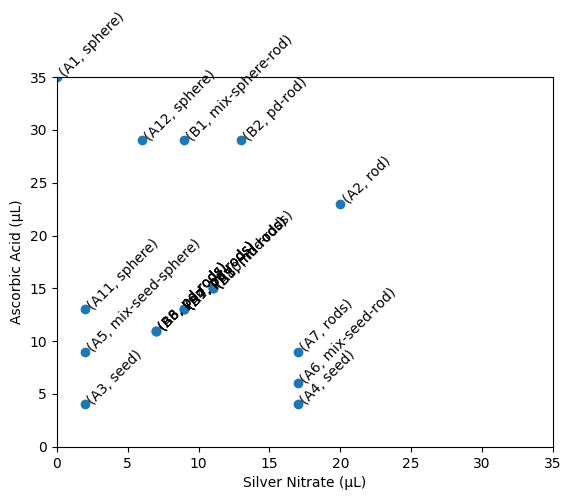

In [9]:
fig, ax = plt.subplots()
design_space_bounds = [(0.0, 35.0), (0.0, 35.0)]
bounds = np.asarray(design_space_bounds).T
ax.scatter(volume_df["SN"], volume_df["AA"])
for i in range(volume_df.shape[0]):
    q, r = divmod(i, 12)
    well_rows = ["A", "B"]
    label = "(%s%d, %s)"%(well_rows[q],r+1, expected_labels[i])
    ax.text(volume_df["SN"][i], volume_df["AA"][i], label, rotation=45)
ax.set_xlim([bounds[0,0], bounds[1,0]])
ax.set_ylim([bounds[0,1], bounds[1,1]])
ax.set_xlabel("Silver Nitrate (µL)")
ax.set_ylabel("Ascorbic Acid (µL)")
plt.show()

In [10]:
well_name_labels = []
row_names = ["A", "B"]
for i in range(volume_df.shape[0]):
    q, r = divmod(i, 12)
    well_name_labels.append(["%s%d"%(row_names[q],r+1), 
                             "%s"%expected_labels[i]]
                             )
tem_sample_info = pd.DataFrame(well_name_labels, columns=["well_name", "label"])
tem_sample_info.loc[[0, 1],"notes"] = "retrosynthesis target"
tem_sample_info.loc[14,"notes"] = "repeats of A8 for TEM"
tem_sample_info.loc[15,"notes"] = "repeats of A9 for TEM"
tem_sample_info.loc[16,"notes"] = "repeats of A10 for TEM"
tem_sample_info.loc[17,"notes"] = "repeats of A8 for Centrifuge"
tem_sample_info.loc[18,"notes"] = "repeats of A9 for Centrifuge"
tem_sample_info.loc[19,"notes"] = "repeats of A10 for Centrifuge"

In [11]:
tem_sample_info.to_csv("./sample_info.csv")

In [12]:
volume_df.to_csv('../opentrons/volumes_tem.csv',index=False)

In [13]:
tem_sample_info

,well_name,label,notes
0,A1,sphere,retrosynthesis target
1,A2,rod,retrosynthesis target
2,A3,seed,NaN
3,A4,seed,NaN
4,A5,mix-seed-sphere,NaN
5,A6,mix-seed-rod,NaN
6,A7,rods,NaN
7,A8,pd-rods,NaN
8,A9,pd-rods,NaN
9,A10,md-rods,NaN
